<h2> there are two projects here. second one on colour compression using kmeans is quite intersting. should give it a look!

k-Means algorithm works on <b><i>expectation maximization</i></b>, which is a powerful algorithm that comes up in various contexts. it's simple and easy to understand:<br>
- guess number of clusters
- repear until coonverged
    - e step: assign points to nearest cluster center
    - m step: set the cluster center to the mean
e = expectation
m = maximization

<h2>k Means on Digits

In [1]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

E:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
E:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [5]:
kmeans = KMeans(n_clusters = 10, random_state = 42)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

the result sis 10 clusters in 64 dimensions<br>let's see what the cluster centers look like

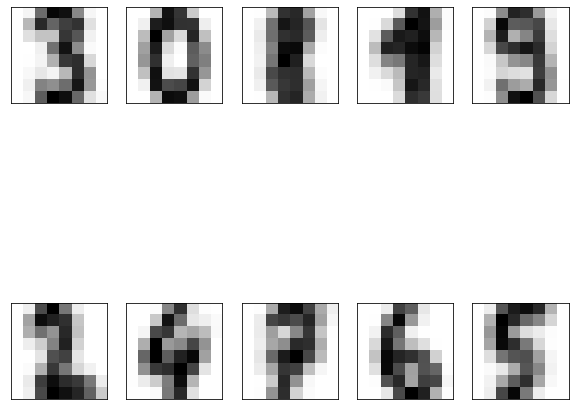

In [6]:
# plot centers
fig, ax = plt.subplots(2, 5, figsize=(10, 10))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

notice how even without labels, KMeans is able to find clusters whose centers are recognizable barring 1 and 8.<br><br>since k means knows nothing of the identity of clusters, the labels may be permuted. can be fixed by matching learned cluster labels with the true labels found in them

In [8]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

now check accuracy of unsupervised cluster in finding similar digits within the data

In [10]:
accuracy_score(digits.target, labels)

0.7924318308291597

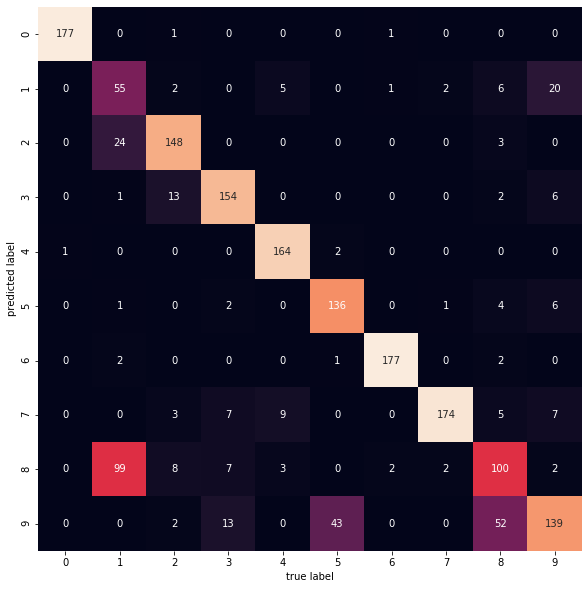

In [14]:
mat = confusion_matrix(digits.target, labels)
plt.subplots(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

as visualised before, most confusion occurs between 1 and 8. despite that it is noticed that a k means classifier can be built <b><i>without referencing any label!!!

<br><br><br><br> pushing this further, we can use the t-distribution stochastic neighbour embedding <b>t-SNE </b>algorithm

In [15]:
from sklearn.manifold import TSNE

In [17]:
# project the data: this will take some time
tsne = TSNE(n_components = 2, init = 'random', random_state = 0)
digits_proj = tsne.fit_transform(digits.data)

# compute clusters
kmeans = KMeans(n_clusters = 10, random_state = 42)
clusters = kmeans.fit_predict(digits_proj)

# permute labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
# calculate the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

<h2> k-Means for colour compression 

In [21]:
from sklearn.datasets import load_sample_image
import warnings; warnings.simplefilter('ignore') 
from sklearn.cluster import MiniBatchKMeans

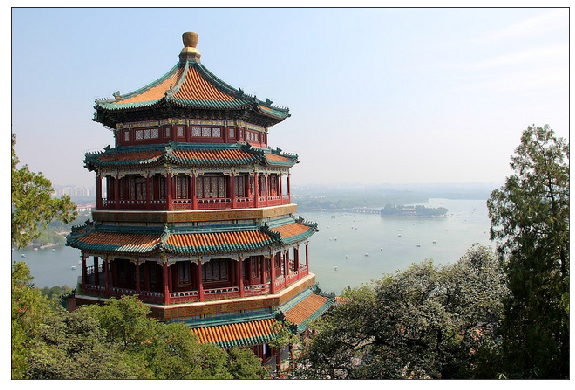

In [23]:
china  = load_sample_image('china.jpg')
plt.subplots(figsize = (10,10))
ax = plt.axes(xticks = [], yticks = [])
ax.imshow(china);

the image itself is stored in a 3 dim array (height, width, RGB), containing rgb contributions from int(0 to 255)

In [24]:
china.shape

(427, 640, 3)

to view these as cloud of points in a 3 dim colour space we shall reshape the data to [n_samples x n_features] and rescale the colours to lie between 0 and 1

In [28]:
data = china / 255.0 # to scale between 0 and 1
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency

In [29]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

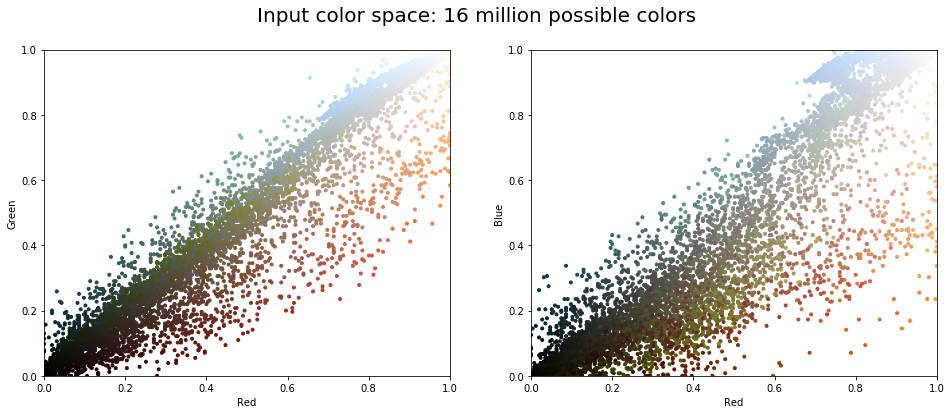

In [30]:
plot_pixels(data, title='Input color space: 16 million possible colors')

<br><br>let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space

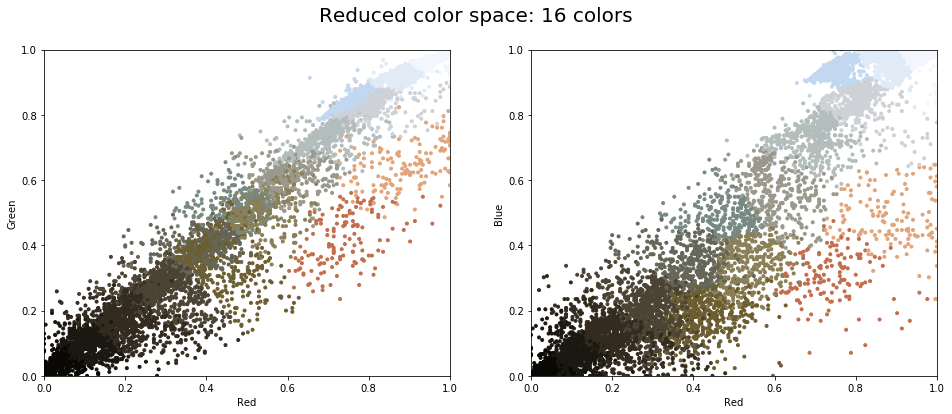

In [31]:
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

result is a recolouring of pixels, where each pixel is assigned the colour closest of it cluster center. <br><br>plotting the image with these new colours

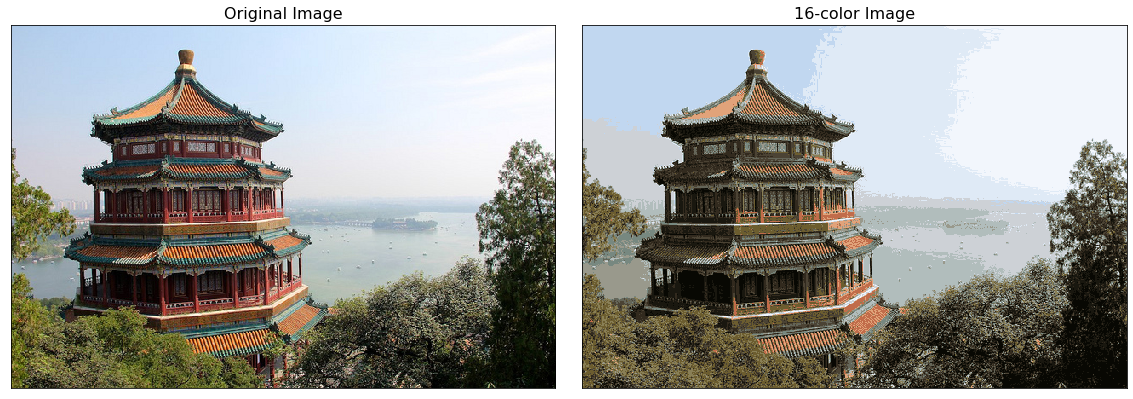

In [34]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 15),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

some detail is definitely lost in the right panel but overall the image is still recognizable. the image on the right achieves a compression factor of one million

this example simply demonstrate what all can be achieved from kmeans by thinking out of the box